In [1]:
%matplotlib inline
import torch
import torchvision
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import PIL.ImageOps 
print(torch.__version__)  #1.1.0
print(torchvision.__version__)  #0.3.0
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision import models
import os
import time
import copy
import pickle as pk
from PIL import Image
import random

import sys
sys.path.append("..") 
import d2lzh_pytorch as d2l
import graduation_pytorch as gra


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from torchvision import transforms, datasets

1.0.0
0.2.1


In [2]:
## 创建训练的向量
# Detect if we have a GPU available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device:',device)
batch_size = 32
from torch.utils.data import Dataset, DataLoader
def dataLoader():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    # mean = [0.485, 0.456, 0.406]  std = [0.229, 0.224, 0.225]
    train_augs = transforms.Compose([
        transforms.RandomResizedCrop(size=224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ])
    ##  !! train
    Gallery_dataset = datasets.ImageFolder(root='../数据集/UCMerced_LandUse/data/train', transform=train_augs)
    return Gallery_dataset
Gallery_dataset = dataLoader()
Gallery_loader = DataLoader(Gallery_dataset,
                           batch_size = 32, shuffle=False)

device: cuda


In [3]:
Gallery_dataset

Dataset ImageFolder
    Number of datapoints: 1680
    Root Location: ../数据集/UCMerced_LandUse/data/train
    Transforms (if any): Compose(
                             RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
                             RandomHorizontalFlip(p=0.5)
                             ToTensor()
                             Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                         )
    Target Transforms (if any): None

In [3]:
from graduation_pytorch.pooling import RMAC

In [4]:
## 加载模型：resnet34_whurisi_remote_finetune_
pretrained_net = models.resnet34(pretrained=True)
pretrained_net.fc = nn.Linear(512, 21)

pretrained_net.avgpool = RMAC()
PATH = "./my_model/rmac_L=2_UcRemote_resnet34_fine-tune.pt" # rmac  滑动窗口

pretrained_net.fc = nn.Sequential()
pretrained_net.load_state_dict(torch.load(PATH))

In [5]:
pretrained_net = pretrained_net.to(device)

In [6]:
# 用于将图片转化成向量
pretrained_net.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [34]:
i = 0
# Iterate over data.
for inputs, labels in Gallery_loader:
    i += 1
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = pretrained_net(inputs)
    if i == 1:
        break

In [36]:
outputs.shape

torch.Size([32, 512])

## demo 一个简单的只涉及全连接层的网络，使用对比损失

In [37]:
#自定义Dataset类，__getitem__(self,index)每次返回(img1, img2, 0/1) 返回相同0  或不同类图片1
class UcLandSiameseNetworkDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs) #37个类别中任选一个       待
        should_get_same_class = random.randint(0,1) #保证同类样本约占一半  0: 50%  1: 50%
        if should_get_same_class:
            while True:
                #直到找到同一类别  找到为止
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            while True:
                #直到找到非同一类别
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] !=img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1, torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [42]:
#定义文件dataset
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# mean = [0.485, 0.456, 0.406]  std = [0.229, 0.224, 0.225]
train_augs = transforms.Compose([
    transforms.RandomResizedCrop(size=224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])
training_dir = '../数据集/UCMerced_LandUse/data/train'  #训练集地址
folder_dataset = torchvision.datasets.ImageFolder(root=training_dir, transform=train_augs)

In [49]:
#定义图像dataset
siamese_dataset = UcLandSiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=train_augs,
                                        should_invert=False)

In [51]:
siamese_dataset[0][1].shape

torch.Size([3, 224, 224])

In [60]:
#定义图像dataloader
train_dataloader = DataLoader(siamese_dataset,
                            shuffle=True,
                            batch_size=32)

In [7]:
#搭建模型
class SiameseNetwork(nn.Module):
    
    def __init__(self):
        super().__init__()
        num_inputs, num_outputs, num_hiddens = 512, 512, 1024
        # 转向量
        self.pre = pretrained_net

        self.fc1 = nn.Sequential(
            nn.Linear(num_inputs, num_hiddens),
            nn.ReLU(),
            nn.Linear(num_hiddens, num_outputs), 
        )

    def forward_once(self, x):
        output = self.pre(x)
#         output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2
    
    
#自定义ContrastiveLoss
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        # 公式
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +  
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))

        return loss_contrastive

In [8]:
net = SiameseNetwork().cuda() #定义模型且移至GPU

In [57]:
criterion = ContrastiveLoss() #定义损失函数
optimizer = optim.Adam(net.parameters(), lr = 0.0005) #定义优化器

Epoch number: 0 , Current loss: 1.4577

Epoch number: 1 , Current loss: 1.3215

Epoch number: 2 , Current loss: 1.2067

Epoch number: 3 , Current loss: 1.1659

Epoch number: 4 , Current loss: 1.1277



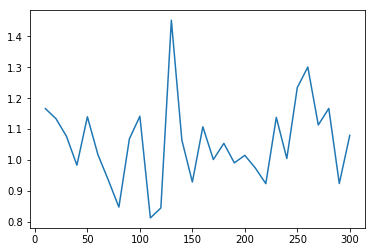

In [63]:
def show_plot(iteration,loss):
    #绘制损失变化图
    plt.plot(iteration,loss)
    plt.show()
num_epochs = 5

counter = []
loss_history = [] 
iteration_number = 0

#开始训练
for epoch in range(0, num_epochs):
    for i, data in enumerate(train_dataloader, 0):
        img0, img1 , label = data
        #img0维度为torch.Size([32, 1, 100, 100])，32是batch，label为torch.Size([32, 1])
        img0, img1 , label = img0.cuda(), img1.cuda(), label.cuda() #数据移至GPU
        optimizer.zero_grad()
        output1,output2 = net(img0, img1)
        loss_contrastive = criterion(output1, output2, label)
        loss_contrastive.backward()
        optimizer.step()
        if i % 10 == 0 :
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())
    print("Epoch number: {} , Current loss: {:.4f}\n".format(epoch,loss_contrastive.item()))
    
show_plot(counter, loss_history)

In [65]:
net.eval()
for i, data in enumerate(train_dataloader, 0):
    img0, img1 , label = data
    img0, img1 , label = img0.cuda(), img1.cuda(), label.cuda() #数据移至GPU
    output = net.forward_once(img0)
    if i == 2:
        break

In [68]:
output.shape

torch.Size([32, 512])

In [69]:
ff = outputs.data.cpu()
# norm feature
fnorm = torch.norm(ff, p=2, dim=1, keepdim=True)
ff = ff.div(fnorm.expand_as(ff))

In [70]:
ff.shape

torch.Size([32, 512])

In [71]:
# 封装距离比较函数
def similarity_of_two(img_data1, img_data2):
    out = (img_data1*img_data2)
    return out.sum()

In [73]:
similarity_of_two(ff[0], ff[1])

tensor(0.9553)

In [74]:
PATH = "./my_model/test1_conLoss_rmac_L=2_UcRemote_resnet34_fine-tune.pt"
torch.save(net.state_dict(), PATH)

## 使用测试集测试

In [9]:
net = SiameseNetwork() #定义模型且移至GPU
PATH = "./my_model/test1_conLoss_rmac_L=2_UcRemote_resnet34_fine-tune.pt"
pretrained_net.load_state_dict(torch.load(PATH))
# net

RuntimeError: Error(s) in loading state_dict for ResNet:
	Missing key(s) in state_dict: "conv1.weight", "bn1.weight", "bn1.bias", "bn1.running_mean", "bn1.running_var", "layer1.0.conv1.weight", "layer1.0.bn1.weight", "layer1.0.bn1.bias", "layer1.0.bn1.running_mean", "layer1.0.bn1.running_var", "layer1.0.conv2.weight", "layer1.0.bn2.weight", "layer1.0.bn2.bias", "layer1.0.bn2.running_mean", "layer1.0.bn2.running_var", "layer1.1.conv1.weight", "layer1.1.bn1.weight", "layer1.1.bn1.bias", "layer1.1.bn1.running_mean", "layer1.1.bn1.running_var", "layer1.1.conv2.weight", "layer1.1.bn2.weight", "layer1.1.bn2.bias", "layer1.1.bn2.running_mean", "layer1.1.bn2.running_var", "layer1.2.conv1.weight", "layer1.2.bn1.weight", "layer1.2.bn1.bias", "layer1.2.bn1.running_mean", "layer1.2.bn1.running_var", "layer1.2.conv2.weight", "layer1.2.bn2.weight", "layer1.2.bn2.bias", "layer1.2.bn2.running_mean", "layer1.2.bn2.running_var", "layer2.0.conv1.weight", "layer2.0.bn1.weight", "layer2.0.bn1.bias", "layer2.0.bn1.running_mean", "layer2.0.bn1.running_var", "layer2.0.conv2.weight", "layer2.0.bn2.weight", "layer2.0.bn2.bias", "layer2.0.bn2.running_mean", "layer2.0.bn2.running_var", "layer2.0.downsample.0.weight", "layer2.0.downsample.1.weight", "layer2.0.downsample.1.bias", "layer2.0.downsample.1.running_mean", "layer2.0.downsample.1.running_var", "layer2.1.conv1.weight", "layer2.1.bn1.weight", "layer2.1.bn1.bias", "layer2.1.bn1.running_mean", "layer2.1.bn1.running_var", "layer2.1.conv2.weight", "layer2.1.bn2.weight", "layer2.1.bn2.bias", "layer2.1.bn2.running_mean", "layer2.1.bn2.running_var", "layer2.2.conv1.weight", "layer2.2.bn1.weight", "layer2.2.bn1.bias", "layer2.2.bn1.running_mean", "layer2.2.bn1.running_var", "layer2.2.conv2.weight", "layer2.2.bn2.weight", "layer2.2.bn2.bias", "layer2.2.bn2.running_mean", "layer2.2.bn2.running_var", "layer2.3.conv1.weight", "layer2.3.bn1.weight", "layer2.3.bn1.bias", "layer2.3.bn1.running_mean", "layer2.3.bn1.running_var", "layer2.3.conv2.weight", "layer2.3.bn2.weight", "layer2.3.bn2.bias", "layer2.3.bn2.running_mean", "layer2.3.bn2.running_var", "layer3.0.conv1.weight", "layer3.0.bn1.weight", "layer3.0.bn1.bias", "layer3.0.bn1.running_mean", "layer3.0.bn1.running_var", "layer3.0.conv2.weight", "layer3.0.bn2.weight", "layer3.0.bn2.bias", "layer3.0.bn2.running_mean", "layer3.0.bn2.running_var", "layer3.0.downsample.0.weight", "layer3.0.downsample.1.weight", "layer3.0.downsample.1.bias", "layer3.0.downsample.1.running_mean", "layer3.0.downsample.1.running_var", "layer3.1.conv1.weight", "layer3.1.bn1.weight", "layer3.1.bn1.bias", "layer3.1.bn1.running_mean", "layer3.1.bn1.running_var", "layer3.1.conv2.weight", "layer3.1.bn2.weight", "layer3.1.bn2.bias", "layer3.1.bn2.running_mean", "layer3.1.bn2.running_var", "layer3.2.conv1.weight", "layer3.2.bn1.weight", "layer3.2.bn1.bias", "layer3.2.bn1.running_mean", "layer3.2.bn1.running_var", "layer3.2.conv2.weight", "layer3.2.bn2.weight", "layer3.2.bn2.bias", "layer3.2.bn2.running_mean", "layer3.2.bn2.running_var", "layer3.3.conv1.weight", "layer3.3.bn1.weight", "layer3.3.bn1.bias", "layer3.3.bn1.running_mean", "layer3.3.bn1.running_var", "layer3.3.conv2.weight", "layer3.3.bn2.weight", "layer3.3.bn2.bias", "layer3.3.bn2.running_mean", "layer3.3.bn2.running_var", "layer3.4.conv1.weight", "layer3.4.bn1.weight", "layer3.4.bn1.bias", "layer3.4.bn1.running_mean", "layer3.4.bn1.running_var", "layer3.4.conv2.weight", "layer3.4.bn2.weight", "layer3.4.bn2.bias", "layer3.4.bn2.running_mean", "layer3.4.bn2.running_var", "layer3.5.conv1.weight", "layer3.5.bn1.weight", "layer3.5.bn1.bias", "layer3.5.bn1.running_mean", "layer3.5.bn1.running_var", "layer3.5.conv2.weight", "layer3.5.bn2.weight", "layer3.5.bn2.bias", "layer3.5.bn2.running_mean", "layer3.5.bn2.running_var", "layer4.0.conv1.weight", "layer4.0.bn1.weight", "layer4.0.bn1.bias", "layer4.0.bn1.running_mean", "layer4.0.bn1.running_var", "layer4.0.conv2.weight", "layer4.0.bn2.weight", "layer4.0.bn2.bias", "layer4.0.bn2.running_mean", "layer4.0.bn2.running_var", "layer4.0.downsample.0.weight", "layer4.0.downsample.1.weight", "layer4.0.downsample.1.bias", "layer4.0.downsample.1.running_mean", "layer4.0.downsample.1.running_var", "layer4.1.conv1.weight", "layer4.1.bn1.weight", "layer4.1.bn1.bias", "layer4.1.bn1.running_mean", "layer4.1.bn1.running_var", "layer4.1.conv2.weight", "layer4.1.bn2.weight", "layer4.1.bn2.bias", "layer4.1.bn2.running_mean", "layer4.1.bn2.running_var", "layer4.2.conv1.weight", "layer4.2.bn1.weight", "layer4.2.bn1.bias", "layer4.2.bn1.running_mean", "layer4.2.bn1.running_var", "layer4.2.conv2.weight", "layer4.2.bn2.weight", "layer4.2.bn2.bias", "layer4.2.bn2.running_mean", "layer4.2.bn2.running_var". 
	Unexpected key(s) in state_dict: "pre.conv1.weight", "pre.bn1.weight", "pre.bn1.bias", "pre.bn1.running_mean", "pre.bn1.running_var", "pre.bn1.num_batches_tracked", "pre.layer1.0.conv1.weight", "pre.layer1.0.bn1.weight", "pre.layer1.0.bn1.bias", "pre.layer1.0.bn1.running_mean", "pre.layer1.0.bn1.running_var", "pre.layer1.0.bn1.num_batches_tracked", "pre.layer1.0.conv2.weight", "pre.layer1.0.bn2.weight", "pre.layer1.0.bn2.bias", "pre.layer1.0.bn2.running_mean", "pre.layer1.0.bn2.running_var", "pre.layer1.0.bn2.num_batches_tracked", "pre.layer1.1.conv1.weight", "pre.layer1.1.bn1.weight", "pre.layer1.1.bn1.bias", "pre.layer1.1.bn1.running_mean", "pre.layer1.1.bn1.running_var", "pre.layer1.1.bn1.num_batches_tracked", "pre.layer1.1.conv2.weight", "pre.layer1.1.bn2.weight", "pre.layer1.1.bn2.bias", "pre.layer1.1.bn2.running_mean", "pre.layer1.1.bn2.running_var", "pre.layer1.1.bn2.num_batches_tracked", "pre.layer1.2.conv1.weight", "pre.layer1.2.bn1.weight", "pre.layer1.2.bn1.bias", "pre.layer1.2.bn1.running_mean", "pre.layer1.2.bn1.running_var", "pre.layer1.2.bn1.num_batches_tracked", "pre.layer1.2.conv2.weight", "pre.layer1.2.bn2.weight", "pre.layer1.2.bn2.bias", "pre.layer1.2.bn2.running_mean", "pre.layer1.2.bn2.running_var", "pre.layer1.2.bn2.num_batches_tracked", "pre.layer2.0.conv1.weight", "pre.layer2.0.bn1.weight", "pre.layer2.0.bn1.bias", "pre.layer2.0.bn1.running_mean", "pre.layer2.0.bn1.running_var", "pre.layer2.0.bn1.num_batches_tracked", "pre.layer2.0.conv2.weight", "pre.layer2.0.bn2.weight", "pre.layer2.0.bn2.bias", "pre.layer2.0.bn2.running_mean", "pre.layer2.0.bn2.running_var", "pre.layer2.0.bn2.num_batches_tracked", "pre.layer2.0.downsample.0.weight", "pre.layer2.0.downsample.1.weight", "pre.layer2.0.downsample.1.bias", "pre.layer2.0.downsample.1.running_mean", "pre.layer2.0.downsample.1.running_var", "pre.layer2.0.downsample.1.num_batches_tracked", "pre.layer2.1.conv1.weight", "pre.layer2.1.bn1.weight", "pre.layer2.1.bn1.bias", "pre.layer2.1.bn1.running_mean", "pre.layer2.1.bn1.running_var", "pre.layer2.1.bn1.num_batches_tracked", "pre.layer2.1.conv2.weight", "pre.layer2.1.bn2.weight", "pre.layer2.1.bn2.bias", "pre.layer2.1.bn2.running_mean", "pre.layer2.1.bn2.running_var", "pre.layer2.1.bn2.num_batches_tracked", "pre.layer2.2.conv1.weight", "pre.layer2.2.bn1.weight", "pre.layer2.2.bn1.bias", "pre.layer2.2.bn1.running_mean", "pre.layer2.2.bn1.running_var", "pre.layer2.2.bn1.num_batches_tracked", "pre.layer2.2.conv2.weight", "pre.layer2.2.bn2.weight", "pre.layer2.2.bn2.bias", "pre.layer2.2.bn2.running_mean", "pre.layer2.2.bn2.running_var", "pre.layer2.2.bn2.num_batches_tracked", "pre.layer2.3.conv1.weight", "pre.layer2.3.bn1.weight", "pre.layer2.3.bn1.bias", "pre.layer2.3.bn1.running_mean", "pre.layer2.3.bn1.running_var", "pre.layer2.3.bn1.num_batches_tracked", "pre.layer2.3.conv2.weight", "pre.layer2.3.bn2.weight", "pre.layer2.3.bn2.bias", "pre.layer2.3.bn2.running_mean", "pre.layer2.3.bn2.running_var", "pre.layer2.3.bn2.num_batches_tracked", "pre.layer3.0.conv1.weight", "pre.layer3.0.bn1.weight", "pre.layer3.0.bn1.bias", "pre.layer3.0.bn1.running_mean", "pre.layer3.0.bn1.running_var", "pre.layer3.0.bn1.num_batches_tracked", "pre.layer3.0.conv2.weight", "pre.layer3.0.bn2.weight", "pre.layer3.0.bn2.bias", "pre.layer3.0.bn2.running_mean", "pre.layer3.0.bn2.running_var", "pre.layer3.0.bn2.num_batches_tracked", "pre.layer3.0.downsample.0.weight", "pre.layer3.0.downsample.1.weight", "pre.layer3.0.downsample.1.bias", "pre.layer3.0.downsample.1.running_mean", "pre.layer3.0.downsample.1.running_var", "pre.layer3.0.downsample.1.num_batches_tracked", "pre.layer3.1.conv1.weight", "pre.layer3.1.bn1.weight", "pre.layer3.1.bn1.bias", "pre.layer3.1.bn1.running_mean", "pre.layer3.1.bn1.running_var", "pre.layer3.1.bn1.num_batches_tracked", "pre.layer3.1.conv2.weight", "pre.layer3.1.bn2.weight", "pre.layer3.1.bn2.bias", "pre.layer3.1.bn2.running_mean", "pre.layer3.1.bn2.running_var", "pre.layer3.1.bn2.num_batches_tracked", "pre.layer3.2.conv1.weight", "pre.layer3.2.bn1.weight", "pre.layer3.2.bn1.bias", "pre.layer3.2.bn1.running_mean", "pre.layer3.2.bn1.running_var", "pre.layer3.2.bn1.num_batches_tracked", "pre.layer3.2.conv2.weight", "pre.layer3.2.bn2.weight", "pre.layer3.2.bn2.bias", "pre.layer3.2.bn2.running_mean", "pre.layer3.2.bn2.running_var", "pre.layer3.2.bn2.num_batches_tracked", "pre.layer3.3.conv1.weight", "pre.layer3.3.bn1.weight", "pre.layer3.3.bn1.bias", "pre.layer3.3.bn1.running_mean", "pre.layer3.3.bn1.running_var", "pre.layer3.3.bn1.num_batches_tracked", "pre.layer3.3.conv2.weight", "pre.layer3.3.bn2.weight", "pre.layer3.3.bn2.bias", "pre.layer3.3.bn2.running_mean", "pre.layer3.3.bn2.running_var", "pre.layer3.3.bn2.num_batches_tracked", "pre.layer3.4.conv1.weight", "pre.layer3.4.bn1.weight", "pre.layer3.4.bn1.bias", "pre.layer3.4.bn1.running_mean", "pre.layer3.4.bn1.running_var", "pre.layer3.4.bn1.num_batches_tracked", "pre.layer3.4.conv2.weight", "pre.layer3.4.bn2.weight", "pre.layer3.4.bn2.bias", "pre.layer3.4.bn2.running_mean", "pre.layer3.4.bn2.running_var", "pre.layer3.4.bn2.num_batches_tracked", "pre.layer3.5.conv1.weight", "pre.layer3.5.bn1.weight", "pre.layer3.5.bn1.bias", "pre.layer3.5.bn1.running_mean", "pre.layer3.5.bn1.running_var", "pre.layer3.5.bn1.num_batches_tracked", "pre.layer3.5.conv2.weight", "pre.layer3.5.bn2.weight", "pre.layer3.5.bn2.bias", "pre.layer3.5.bn2.running_mean", "pre.layer3.5.bn2.running_var", "pre.layer3.5.bn2.num_batches_tracked", "pre.layer4.0.conv1.weight", "pre.layer4.0.bn1.weight", "pre.layer4.0.bn1.bias", "pre.layer4.0.bn1.running_mean", "pre.layer4.0.bn1.running_var", "pre.layer4.0.bn1.num_batches_tracked", "pre.layer4.0.conv2.weight", "pre.layer4.0.bn2.weight", "pre.layer4.0.bn2.bias", "pre.layer4.0.bn2.running_mean", "pre.layer4.0.bn2.running_var", "pre.layer4.0.bn2.num_batches_tracked", "pre.layer4.0.downsample.0.weight", "pre.layer4.0.downsample.1.weight", "pre.layer4.0.downsample.1.bias", "pre.layer4.0.downsample.1.running_mean", "pre.layer4.0.downsample.1.running_var", "pre.layer4.0.downsample.1.num_batches_tracked", "pre.layer4.1.conv1.weight", "pre.layer4.1.bn1.weight", "pre.layer4.1.bn1.bias", "pre.layer4.1.bn1.running_mean", "pre.layer4.1.bn1.running_var", "pre.layer4.1.bn1.num_batches_tracked", "pre.layer4.1.conv2.weight", "pre.layer4.1.bn2.weight", "pre.layer4.1.bn2.bias", "pre.layer4.1.bn2.running_mean", "pre.layer4.1.bn2.running_var", "pre.layer4.1.bn2.num_batches_tracked", "pre.layer4.2.conv1.weight", "pre.layer4.2.bn1.weight", "pre.layer4.2.bn1.bias", "pre.layer4.2.bn1.running_mean", "pre.layer4.2.bn1.running_var", "pre.layer4.2.bn1.num_batches_tracked", "pre.layer4.2.conv2.weight", "pre.layer4.2.bn2.weight", "pre.layer4.2.bn2.bias", "pre.layer4.2.bn2.running_mean", "pre.layer4.2.bn2.running_var", "pre.layer4.2.bn2.num_batches_tracked", "fc1.0.weight", "fc1.0.bias", "fc1.2.weight", "fc1.2.bias". 

In [75]:
from torch.utils.data import Dataset, DataLoader
def dataLoader():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    # mean = [0.485, 0.456, 0.406]  std = [0.229, 0.224, 0.225]
    test_augs = transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        normalize
    ])
    Gallery_dataset = datasets.ImageFolder(root='../数据集/UCMerced_LandUse/data/test', transform=test_augs)
#     Gallery_dataset = datasets.ImageFolder(root='../数据集/Google dataset of SIRI-WHU_earth_im_tiff/12class_tif', transform=test_augs)
    return Gallery_dataset
Gallery_dataset = dataLoader()
Gallery_loader = DataLoader(Gallery_dataset,
                           batch_size = 32, shuffle=False)

In [77]:
# save to loacl file
# save_path = './features/maxPooling_UcRemote21-train-resnet'
# save_path = './features/gem_p=3_UcRemote21-train-resnet'
save_path = './features/test1_conLoss_rmac_L=2_UcRemote21-train-resnet'

def save_data(file, data):
    f = open(file, 'wb+')
    pk.dump(data, f, 0)
    f.close()


def extract_features(model, loader):
    since = time.time()
    features = torch.FloatTensor()
         
    model.eval()

    # Iterate over data.
    for inputs, labels in loader:

        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model.forward_once(inputs)
        ff = outputs.data.cpu()
        # norm feature
        fnorm = torch.norm(ff, p=2, dim=1, keepdim=True)
        ff = ff.div(fnorm.expand_as(ff))
        features = torch.cat((features, ff), 0)

    time_elapsed = time.time() - since
    print('Feature extraction complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    
    return features

if os.path.exists(save_path):
    fo = open(save_path, 'rb')
    features = pk.load(fo, encoding='bytes')
    fo.close()
    print("Load features.")
else:
    features = extract_features(net, Gallery_loader)
    save_data(save_path, features)
    print("Save features to %s" % (save_path))

RuntimeError: CUDA out of memory. Tried to allocate 98.00 MiB (GPU 0; 6.00 GiB total capacity; 4.50 GiB already allocated; 57.01 MiB free; 65.00 MiB cached)